In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
crypto = "AUCTION"
df = pd.read_csv(f"data/{crypto}.csv")
df["timestamp"] = [int(datetime.timestamp(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))) for x in df["datetime"]]
df.set_index('timestamp', inplace=True)
df

,datetime,open,high,low,close,volume,hourly
timestamp,,,,,,,
1700409600,2023-11-20 00:00:00,8.85,8.90,8.83,8.88,3621.43,0
1700410500,2023-11-20 00:15:00,8.88,8.89,8.83,8.83,1631.77,0
1700411400,2023-11-20 00:30:00,8.83,8.85,8.81,8.84,1278.22,0
1700412300,2023-11-20 00:45:00,8.82,8.84,8.81,8.83,1005.11,0
1700413200,2023-11-20 01:00:00,8.82,8.87,8.82,8.85,1372.55,1
...,...,...,...,...,...,...,...
1702139400,2023-12-10 00:30:00,17.03,17.19,17.03,17.14,4503.16,0
1702140300,2023-12-10 00:45:00,17.11,17.18,17.08,17.16,1958.15,0
1702141200,2023-12-10 01:00:00,17.15,17.15,16.82,16.88,7630.96,1


In [3]:
# Extract features and target
features = df.index.astype(int) // (90 * 10)
print(features)

Index([1889344, 1889345, 1889346, 1889347, 1889348, 1889349, 1889350, 1889351,
       1889352, 1889353,
       ...
       1891261, 1891262, 1891263, 1891264, 1891265, 1891266, 1891267, 1891268,
       1891269, 1891270],
      dtype='int32', name='timestamp', length=1927)


In [4]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['open']])

In [5]:
# Function to create input sequences and labels
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length][0])
    return np.array(X), np.array(y)


# Set the sequence length
sequence_length = 24

In [6]:
# Create sequences and labels
X, y = create_sequences(df_scaled, sequence_length)
print(X.shape)
print(y.shape)
print(X)

(1903, 24, 1)
(1903,)
[[[0.0358505 ]
  [0.03813883]
  [0.03432494]
  ...
  [0.04576659]
  [0.05110603]
  [0.04729214]]

 [[0.03813883]
  [0.03432494]
  [0.03356217]
  ...
  [0.05110603]
  [0.04729214]
  [0.0488177 ]]

 [[0.03432494]
  [0.03356217]
  [0.03356217]
  ...
  [0.04729214]
  [0.0488177 ]
  [0.04729214]]

 ...

 [[0.69183829]
  [0.68954996]
  [0.68344775]
  ...
  [0.66742944]
  [0.65980168]
  [0.66590389]]

 [[0.68954996]
  [0.68344775]
  [0.68115942]
  ...
  [0.65980168]
  [0.66590389]
  [0.668955  ]]

 [[0.68344775]
  [0.68115942]
  [0.68954996]
  ...
  [0.66590389]
  [0.668955  ]
  [0.64836003]]]


In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train the model
model.fit(X, y, epochs=20, batch_size=16)

Epoch 1/20
119/119 [==============================] - 5s 15ms/step - loss: 0.0081
Epoch 2/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0030
Epoch 3/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0025
Epoch 4/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0026
Epoch 5/20
119/119 [==============================] - 2s 16ms/step - loss: 0.0024
Epoch 6/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0023
Epoch 7/20
119/119 [==============================] - 2s 16ms/step - loss: 0.0020
Epoch 8/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0018
Epoch 9/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0018
Epoch 10/20
119/119 [==============================] - 2s 16ms/step - loss: 0.0018
Epoch 11/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0016
Epoch 12/20
119/119 [==============================] - 2s 15ms/step - loss: 0.0017
Epoch 13/20
1

In [9]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['open']])

In [10]:
# Make predictions
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(np.reshape(y_pred, (-1, 1))).reshape(-1)
y_real = scaler.inverse_transform(np.reshape(y, (-1, 1))).reshape(-1)

prediction_dict = {'timestamp': features[:-sequence_length], 'real_price': y_real, 'predicted_price': y_pred}
df_pred = pd.DataFrame.from_dict(prediction_dict)
#df_pred['datetime'] = pd.to_datetime(df['datetime'])

60/60 [==============================] - 2s 7ms/step


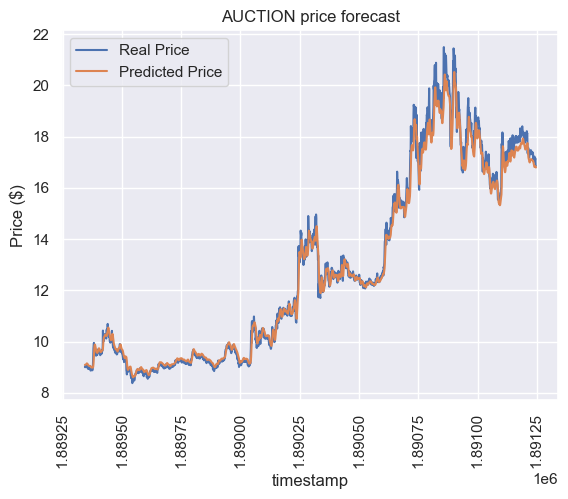

In [11]:
# Plot the results
sns.lineplot(df_pred, x = "timestamp", y = "real_price", label="Real Price")
sns.lineplot(df_pred, x = "timestamp", y = "predicted_price", label="Predicted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()

In [12]:
print(y_pred[-1])

16.792976


1/1 [==============================] - 0s 23ms/step


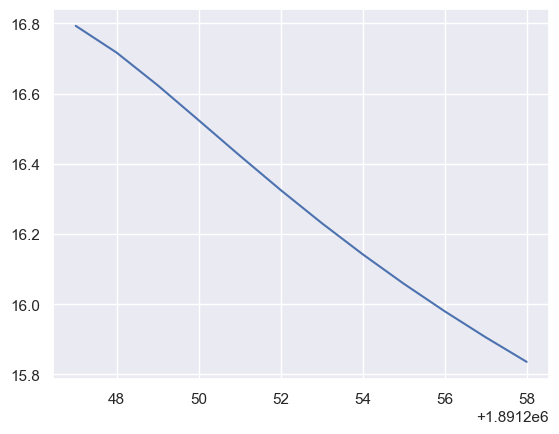

In [13]:
def forecast(data, futur):
    arr = np.expand_dims(data[-1], axis=0)
    L = []
    for _ in range(futur):
        prediction = model.predict(arr)
        arr = np.append(arr, prediction)
        arr = np.delete(arr, 0)
        arr = np.expand_dims(arr, axis=0)
        arr = np.expand_dims(arr, axis=2)
        L.append(prediction[0][0])
    return L

nb_hours = 12
yForecast = forecast(X, nb_hours)
yForecast = scaler.inverse_transform(np.reshape(yForecast, (-1, 1))).reshape(-1)
xForecast = range(features[-sequence_length],features[-sequence_length] + nb_hours)

forecast_dict = {"timestamp" : xForecast, "forecasted_price": yForecast}
df_forecast = pd.DataFrame.from_dict(forecast_dict)
plt.plot(xForecast, yForecast)

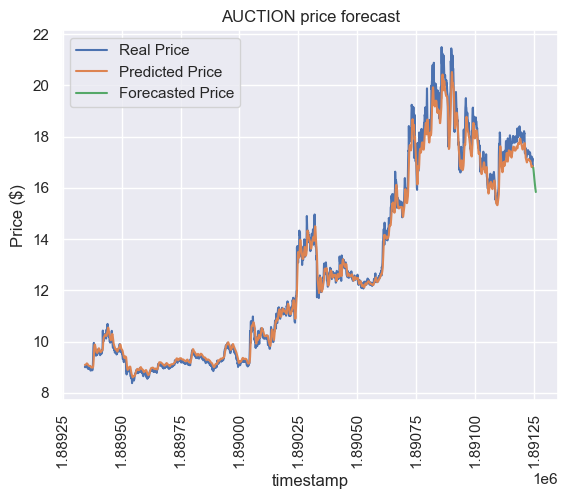

In [14]:
# Plot the results
sns.lineplot(df_pred, x = "timestamp", y = "real_price", label="Real Price")
sns.lineplot(df_pred, x = "timestamp", y = "predicted_price", label="Predicted Price")
sns.lineplot(df_forecast, x = "timestamp", y = "forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()